<a href="https://colab.research.google.com/github/parikshit23/Computational-Linear-Algebra/blob/master/topic_modelling_with_nmf_and_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Topic Modeling with NMF and SVD
We'll take a set of documents in several different categories and find topics(consisting of group of words) for them. Knowing the actual categories helps us evaluate if the topics we find make sense

We will try this with two different matrix factorizations: <b>Singular value Decomposition (SVD) </b> and <b> Non negative Matrix Factorization (NMF) </b> 

In [0]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Setting up the data

Scikit Learn comes with a number of built-in datasets, as well as loading utilities to load several standard external datasets. We will be using the newsgroups dataset.

Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off. This dataset includes 18,000 newsgroups posts with 20 topics.

We will use only 4 categories out of the 20. This can be done by specifying the categories we want to use as follows:

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

Lets look how is the data structured

In [3]:
# Keys of the data
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
# how are the posts stored
newsgroups_train.data[:10]

["Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych",
 '\n\nSeems to be, barring evidence to the contrary, that Koresh was simply\nanother deranged fanatic who thought it neccessary to take a whole bunch of\nfolks with him, children and all, to satisfy his delusional mania. Jim\nJones, circa 1993.\n\n\nNope - fruitcakes like Koresh have been demonstrating such evil corruption\nfor centuries.',
 "\n >In article <1993Apr19.020

In [5]:
# how are the target_names stored
newsgroups_train.target_names[:10]

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [5]:
# how are the target stored
newsgroups_train.data[:10]

["Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych",
 '\n\nSeems to be, barring evidence to the contrary, that Koresh was simply\nanother deranged fanatic who thought it neccessary to take a whole bunch of\nfolks with him, children and all, to satisfy his delusional mania. Jim\nJones, circa 1993.\n\n\nNope - fruitcakes like Koresh have been demonstrating such evil corruption\nfor centuries.',
 "\n >In article <1993Apr19.020

In [7]:
# What is DESCR are the target stored
newsgroups_train.DESCR

'.. _20newsgroups_dataset:\n\nThe 20 newsgroups text dataset\n------------------------------\n\nThe 20 newsgroups dataset comprises around 18000 newsgroups posts on\n20 topics split in two subsets: one for training (or development)\nand the other one for testing (or for performance evaluation). The split\nbetween the train and test set is based upon a messages posted before\nand after a specific date.\n\nThis module contains two loaders. The first one,\n:func:`sklearn.datasets.fetch_20newsgroups`,\nreturns a list of the raw texts that can be fed to text feature\nextractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`\nwith custom parameters so as to extract feature vectors.\nThe second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,\nreturns ready-to-use features, i.e., it is not necessary to use a feature\nextractor.\n\n**Data Set Characteristics:**\n\n    =================   ==========\n    Classes                     20\n    Samples total            

In [8]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Let's look at some of the data

In [9]:
print('\n'.join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [10]:
#What are the target names of the forst three posts
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

In [11]:
newsgroups_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

The target attribute is the integer index of the category

In [12]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

## Countvectorizer
Next, We want to extract the word counts for words occuring in all the posts.
Scikit learn has a method that will extract all the word counts for us.
The function Countvectorizer converts a collection of text documents to a matrix of token counts
This implementation produces a sparse representation of the counts 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [6]:
print(len(newsgroups_train.data),vectors.shape)

2034 (2034, 26576)


In [0]:
vocab = np.array(vectorizer.get_feature_names())

In [8]:
vocab.shape

(26576,)

In [18]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

## Singular Value Decomposition (SVD)

Singular Value Decomposition is a dimentionality reduction technique. 
A matrix when decomposed by SVD gives three following matrices as outputs <br> 

U = A left orthogonal matrix <br>
s = A singular matrix (only diagonal elements have values rest is zero)<br>
Vh = A right Orthogonal matrix

In this case the 2034x26576 vectors matrix (result of countvectorizer) is decomposed into three matrices as follows:<br>
U is a 2034x2034 matrix <br>
s is a singular matrix of height 2034 <br>
Vh is a 2034X26576 matrix <br>

The SVD functions as shown in the image below: <br>
![alt text](https://raw.githubusercontent.com/parikshit23/Computational-Linear-Algebra/master/images/SVD.png) <br>

Source:(<a href="https://research.fb.com/fast-randomized-svd/">Facebook Research</a>)



linalg.svd is a scipy function which takes in the vectors matrix and decomposes it into 3 matrices as decribed above.

In [19]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 11s, sys: 3.52 s, total: 1min 15s
Wall time: 38.7 s


In [20]:
print(U.shape,s.shape,Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


Confirming that this is a decomposition by subtracting the product of U,s,Vh from the original vectors matrix. <br>The difference between the 2 should be very close to zero

In [21]:
reconstructed_vectors = U @ np.diag(s) @Vh
np.linalg.norm(reconstructed_vectors-vectors)

3.0400655704971045e-12

Confirming if U, s, Vh is a decomposition of the Vectors <br>


In [22]:
reconstructed_vectors = U @ np.diag(s) @ Vh
np.linalg.norm(reconstructed_vectors-vectors)
np.allclose(reconstructed_vectors,vectors)

True

Confriming that U,Vh are orthonormal

In [23]:
np.allclose(U @ U.T,np.eye(U.shape[0]))
np.allclose(Vh @ Vh.T,np.eye(Vh.shape[0]))

True

### What can we say about singular values?

The singular values indicate the importance. As seen below the importance drops of very quickly. After 125 values the reduction of the importance is very low. <br>

This indicates that we can use the top 125 values and ignore the rest. Thus reducing the dimentionality 


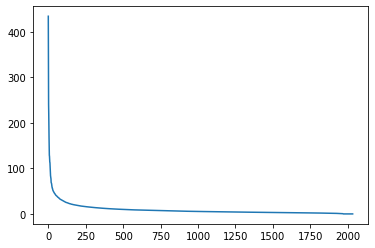

In [24]:
plt.plot(s)

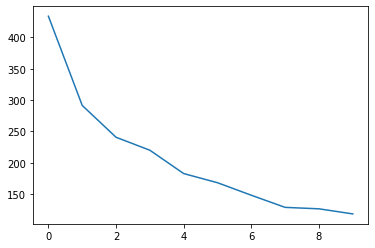

In [25]:
plt.plot(s[:10])

### NMF from sklearn

Non-negative matrix factorization (NMF or NNMF), also non-negative matrix approximation is a group of algorithms in multivariate analysis and linear algebra where a matrix V is factorized into (usually) two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to inspect <br>

Following image is a representation of how NMF works:
![alt text](https://raw.githubusercontent.com/parikshit23/Computational-Linear-Algebra/master/images/nmf_doc.png) <br>




We imported the data with 4 Categories. But there are multiple sub categories in each topic and there is some overlap between topics like Atheism and Religion. So there is no one correct option to choose the number of topics. 

For further copmutations we are using number of topics as 5

In [0]:
m,n=vectors.shape
d=5  # num topics

The vectors matrix has the shape as (2034, 26576) where 2034 are the number of posts (rows of the matrix) and 26576 are the total number of words present in all posts. <br>

The aim is to find two non-negative matrices (W, H) whose product approximates the non-negative matrix X. <br>
This factorization can also be used for dimensionality reduction, source separation or topic extraction.

NMF fit_transform model learns a NMF model for the data and returns the transformed data. 

In the following Code W1 and H1 are the output of NMF which are the two non negative matrices we want to compute. 
Where W1 is a 2034x5 where each row is one post and columns indicate the relative importance of each post to 5 topics. 

Where W1 is a 2034x5 where each row is one post and columns indicate the relative importance of each post to 5 topics. 

H1 is a 5x26576 matrix where each row is one topic and columns indicate the relatove importance of each word to the 5 topics

In [9]:
clf = decomposition.NMF(n_components=d, random_state=1)
W1 = clf.fit_transform(vectors)
H1 = clf.components_
print(W1.shape,H1.shape)

(2034, 5) (5, 26576)


Checking if W1 and H1 give us the matrix of same shape as vectors

In [19]:
(W1@H1).shape

(2034, 26576)

### Helper function to display top 8 words for all topics 

H1 is a 5x26576 matrix where each row is one topic and columns indicate the relative importance of each word to the 5 topics.

The helper function below selects the top 8 most important word for a topic and displays them.

In [0]:
num_top_words=8
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

Checking the top 8 words for the 5 topics

In [11]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

We get topics that match the kind of clusters we would expect. We never told the algorithm how our doucments are grouped or what words belong to which topic. 

### TF-IDF
Topic Frequency Inverse Document Frequency is a way to normalize term counts by taking into account how often they appear in a document, how long the document is and how common/rare the term is.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)



Following is an example of TFIDD works:

In [0]:
corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']
vectorizer = CountVectorizer()

In [0]:
vectorizer=TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [13]:
print(X)

  (0, 1)	0.46979138557992045
  (0, 2)	0.5802858236844359
  (0, 6)	0.38408524091481483
  (0, 3)	0.38408524091481483
  (0, 8)	0.38408524091481483
  (1, 5)	0.5386476208856763
  (1, 1)	0.6876235979836938
  (1, 6)	0.281088674033753
  (1, 3)	0.281088674033753
  (1, 8)	0.281088674033753
  (2, 4)	0.511848512707169
  (2, 7)	0.511848512707169
  (2, 0)	0.511848512707169
  (2, 6)	0.267103787642168
  (2, 3)	0.267103787642168
  (2, 8)	0.267103787642168
  (3, 1)	0.46979138557992045
  (3, 2)	0.5802858236844359
  (3, 6)	0.38408524091481483
  (3, 3)	0.38408524091481483
  (3, 8)	0.38408524091481483


The vectorizer returns a sparse matrix as seen in the above cell. 

In a sparse matrix majority of the elements are zero and when the matrix sizes are large, storing or computing on such marices becomes a very computationaly intensive task. 

In the above cell only the non zero values are stored. For example:
- the value at the location 0x1 in the matrix is 0.46979138557992045
- the value at the location 0x2 in the matrix is 0.5802858236844359
- there is no mention of the loication 0x4 which means that the value at that location is 0 

The matrix looks like follows:

In [34]:
print(X.todense())

[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


Even if the sparse matrix does not store the zero values, it inherits all the properties of the original matrix as seen below

In [35]:
X.shape

(4, 9)

Switching back to the newsgroup example

In [0]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [0]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [24]:
W1.shape,H1.shape

((2034, 5), (5, 26576))

The matrix W1 represents how important is each post to all 5 topics. Rows of the matrix represent the posts and columns represent the topics.

The matrix H1 represents how important is each word to all 5 topics. Rows of the matrix represent the topics and columns represent the corpus of words.

The TfidfVectorizer gives us a matrix of normalize term counts. Then after decomposing it using NMF we end up with two matices H1 and W1. 

As seen in the below cell, we get topics that match the kinds of clusters we would expect! This is despite the fact that this is an unsupervised algorithm - which is to say, we never actually told the algorithm how our documents are grouped. 


In [16]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

In [17]:
# Calculate the error between the two matrices
clf.reconstruction_err_

43.712926057952785

### NMF in summary
- Fast and easy to use
- For NMF, the matrix needs to be at least as tall as its wide, or we get and error in fit_transform

### NMF from scratch

#### Gradient Descent

1. Randomly choose weights to start
2. Loop:
   - Use weights to calculate a prediction
   - Calculate the derivative of the loss
   - Update the weights
3. Repeat step 2 lots of times, till we get decent weights

<b>Key:</b> We want to decrease our loss and the derivate tells us the direction of <b>steepest descent</b>

#### Stocastic gradient descent (SGD)

Stochastic gradient descent is an useful optimization method (it is also the heart of deep learning, where it is used for backpropagation).

For standard gradient descent, we evaluate the loss using all of our data which can be really slow. In stochastic gradient descent, we evaluate our loss function on just a sample of our data (sometimes called a mini-batch). We would get different loss values on different samples of the data, so this is why it is stochastic. It turns out that this is still an effective way to optimize, and it's much more efficient!


Applying SGD to NMF

Goal: Decompose V(m×n) into <br>

V≈WH <br> 

where W(m×d) and H(d×n), W,H>=0, <br> 
and we've minimized the Frobenius norm of V−WH

.

Approach: We will pick random positive W
& H, and then use SGD to optimize.


In [0]:
lam=1e3
lr=0.002
m, n = vectors_tfidf.shape

Grad function in the following cell, calculates the gradients of the loss function, 

Our aim is to find 2 matrices W and H such that their product is equal to M (vectors_tfidf (tfidf value_matrix))

To calculate the loss we take a product of W and H and subtract M from it. 

The Goal is to force the algorithm to go towards positive values of 
W and H. hence there is a panalty when W or H is negative.

In [0]:
mu = 1e-6
def grads(M, W, H):
    R = W@H-M
    return R@H.T + penalty(W, mu)*lam,W.T@R + penalty(H, mu)*lam # dW, dH

The penalty function checks if the values of a matrix are greater than 0. If the value is greater than 0 then there is no penalty. 

If the value is less than 0 then 

In [0]:
def penalty(M, mu):
    return np.where(M>=mu,0, np.min(M - mu, 0))

The update function uses the grad function defined above to calculate the derivatives of the gradients by applying the appropriate penalty.

These derivatives are then multiplied by the learning rate (lr) and againg fed back into the algorithm to calculate the new graidents



In [0]:
def upd(M, W, H, lr):
    dW,dH = grads(M,W,H)
    W -= lr*dW; H -= lr*dH

The report method gives us a sense of how the algorithm is progressing. <br>
Ideally we want the first term  np.linalg.norm(M-W@H) to reduce after every iteration. <br>

The next two terms W.min(), H.min() help us see if the values of the matrices are non negative. <br> 
For initial few iterations the values might be negative, but eventually we should end up we non negatove minimum values of W and H. <br> 

The last two terms (W<0).sum(), (H<0).sum() help us to see how many values in the matrices W and H are negative. This number should go down with every iteration as the algorithm penalises negative terms and pushes itself to return positive values.

In [0]:
def report(M,W,H): 
    print(np.linalg.norm(M-W@H), W.min(), H.min(), (W<0).sum(), (H<0).sum(), (penalty(W, mu)*lam).sum(),(penalty(H, mu)*lam).sum())

In [0]:
W = np.abs(np.random.normal(scale=0.01, size=(m,d)))
H = np.abs(np.random.normal(scale=0.01, size=(d,n)))

Checking the error before we do our first iteration. 

In [35]:
report(vectors_tfidf,W,H)

44.42497301489932 3.708991553498469e-06 1.0554688842057402e-08 0 0 0.0 -0.004366278603203276


updating the weights after first iteration

In [0]:
upd(vectors_tfidf,W,H,lr)

In [37]:
report(vectors_tfidf, W, H)

44.42337484433614 -0.00014984574822973307 -1.3638379091317415e-05 25 50 -2.029339137047133 -0.2500054111951147


As seen above the error has reduced slightly. 

Running the above calculation for 500 iterations...

In [0]:
import time

In [39]:
start = time.time()
for i in range(500): 
    upd(vectors_tfidf,W,H,lr)
    if i % 10 == 0: report(vectors_tfidf,W,H)
end = time.time()
print("Time taken for 500 iterations is:", end-start)

44.42183595299505 -0.0001782299188942912 -1.0592738330121432e-05 29 85 -3.7530216426663747 -0.4255857784881747
44.40899170513983 -0.0001413479084082155 -1.6425150363689896e-05 77 432 -9.169390484513496 -1.8867914905000822
44.39931807710828 -0.00013576505179038214 -1.4483794204468436e-05 150 677 -15.310921961399929 -2.7170635041681614
44.39152595235271 -0.00012031589611032813 -1.3146750624956139e-05 131 881 -13.089322056833236 -3.442339005446358
44.38482925975928 -9.555841497318218e-05 -1.2546136905181612e-05 179 1112 -16.4335315497529 -4.207160507568509
44.37876775215958 -8.16698817491048e-05 -1.2244607805145454e-05 152 1378 -10.646629751284683 -5.136510154302495
44.3730360622559 -8.138705989067327e-05 -1.226855934866322e-05 150 1635 -9.123657624089715 -6.036632171144255
44.367449305054954 -7.839437027747326e-05 -1.2414262408141464e-05 126 1892 -7.344244532276672 -7.012064444201942
44.361880405700326 -6.109610205572367e-05 -1.2642257390532697e-05 160 2175 -8.993023776904847 -8.20227311

As seen above, it takes 330 seconds for 500 iterations to run. Also the error has not decresed a lot and the sum of negative values in matrix H has increased instead of decreasing. 

This tells us that the algorithm need more training. Which will take a lot of time considering for 500 iteration it took 263 seconds. 

To tackle with this issue, we use PyTorch and GPU for faster calculations

### PyTorch

PyTorch is a Python framework for tensors and dynamic neural networks with GPU acceleration. Many of the core contributors work on Facebook's AI team. In many ways, it is similar to Numpy, only with the increased parallelization of using a GPU.

<b> Note </b> If you are not using GPU, make sure to remove all the ".cuda()" from the methods below.

In [0]:
import torch
import torch.cuda as tc
from torch.autograd import Variable

In Pytorch there is a functionality which allows us to keep track of variables as and when they are created. This can be activated by the code below

In [0]:
def V(M):
  return Variable(M, requires_grad=True)

In [0]:
v=vectors_tfidf.todense()

Stroring our vectros matrix as a torch tensor on GPU (using cuda command)

In [0]:
t_vectors = torch.Tensor(v.astype(np.float32)).cuda()

In [0]:
mu = 1e-5

Redifing the methods we used above. 

The key differences are that we are using .MM method of pytorch which allows for matrix multiplication 

Using Torch.clamp to select the maximum value

.sub_ is the same as -= used in the above methods to multiply by -1

In [0]:
def grads_t(M, W, H):
    R = W.mm(H)-M
    return (R.mm(H.t()) + penalty_t(W, mu)*lam,
            W.t().mm(R) + penalty_t(H, mu)*lam) # dW, dH

def penalty_t(M, mu):
    return (M<mu).type(tc.FloatTensor)*torch.clamp(M - mu, max=0.)

def upd_t(M, W, H, lr):
    dW,dH = grads_t(M,W,H)
    W.sub_(lr*dW); H.sub_(lr*dH)

def report_t(M,W,H): 
    print((M-W.mm(H)).norm(2), W.min(), H.min(), (W<0).sum(), (H<0).sum())

Next we will initialise our tensors (matrix W and H) and assign random values.Same as above

In [0]:
t_W = tc.FloatTensor(m,d)
t_H = tc.FloatTensor(d,n)
t_W.normal_(std=0.01).abs_(); 
t_H.normal_(std=0.01).abs_();

In [0]:
d=5; lam=100; lr=0.05

In [48]:
start = time.time()
for i in range(5000): 
    upd_t(t_vectors,t_W,t_H,lr)
    #report the values of every 100th iteration
    if i % 100 == 0: 
        report_t(t_vectors,t_W,t_H)
        lr *= 0.9
end = time.time()

print("time taken for 5000 iterations is", end-start)

tensor(44.3938, device='cuda:0') tensor(-0.0055, device='cuda:0') tensor(-0.0004, device='cuda:0') tensor(809, device='cuda:0') tensor(1429, device='cuda:0')
tensor(43.7599, device='cuda:0') tensor(-0.0123, device='cuda:0') tensor(-0.0142, device='cuda:0') tensor(1338, device='cuda:0') tensor(16556, device='cuda:0')
tensor(43.7237, device='cuda:0') tensor(-0.0055, device='cuda:0') tensor(-0.0113, device='cuda:0') tensor(1594, device='cuda:0') tensor(15555, device='cuda:0')
tensor(43.7141, device='cuda:0') tensor(-0.0059, device='cuda:0') tensor(-0.0057, device='cuda:0') tensor(1855, device='cuda:0') tensor(16481, device='cuda:0')
tensor(43.7133, device='cuda:0') tensor(-0.0051, device='cuda:0') tensor(-0.0040, device='cuda:0') tensor(1949, device='cuda:0') tensor(16944, device='cuda:0')
tensor(43.7126, device='cuda:0') tensor(-0.0042, device='cuda:0') tensor(-0.0050, device='cuda:0') tensor(2456, device='cuda:0') tensor(18707, device='cuda:0')
tensor(43.7123, device='cuda:0') tensor(-0

The time taken for 500 iterations without PyTroch and GPU acceleration is around 263 seconds. 

Where as time taken for 5000 iterations without PyTroch and GPU acceleration is around 79 seconds. 

That is how much the calculations are sped up when using PyTorch and GPU


In [49]:
show_topics(t_H.cpu().numpy())

['graphics thanks files image file program windows know',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'space nasa launch shuttle orbit moon lunar earth',
 'god jesus bible believe christian atheism does belief',
 'people don think just like objective say morality']

## PyTorch: Autograd



Above, we used our knowledge of what the gradient of the loss function was to do SGD from scratch in PyTorch. However, PyTorch has an automatic differentiation package, autograd which we could use instead. This is really useful, in that we can use autograd on problems where we don't know what the derivative is.

The approach we use below is very general, and would work for almost any optimization problem.

In PyTorch, Variables have the same API as tensors, but Variables remember the operations used on to create them. This lets us take derivatives.

Using Autograd for NMF

In [0]:
lam=1e6

In [0]:
pW = Variable(tc.FloatTensor(m,d), requires_grad=True)
pH = Variable(tc.FloatTensor(d,n), requires_grad=True)
pW.data.normal_(std=0.01).abs_()
pH.data.normal_(std=0.01).abs_();

In [0]:
def report():
    W,H = pW.data, pH.data
    print((M-pW.mm(pH)).norm(2).data, W.min(), H.min(), (W<0).sum(), (H<0).sum())

def penalty(A):
    return torch.pow((A<0).type(tc.FloatTensor)*torch.clamp(A, max=0.), 2)

def penalize(): return penalty(pW).mean() + penalty(pH).mean()

def loss(): return (M-pW.mm(pH)).norm(2) + penalize()*lam

In [0]:
M = Variable(t_vectors).cuda()

In [54]:
opt = torch.optim.Adam([pW,pH], lr=1e-3, betas=(0.9,0.9))
lr = 0.05
report()

tensor(44.4254, device='cuda:0') tensor(1.1584e-08, device='cuda:0') tensor(3.8731e-07, device='cuda:0') tensor(0, device='cuda:0') tensor(0, device='cuda:0')


In [56]:
start = time.time()
for i in range(1000):
    #Setting gradients as zero before every iteration 
    opt.zero_grad()
    #Calculating the loss
    l = loss()
    #calculating the gradients
    l.backward()
    #Updating the weights 
    opt.step()
    # Every 100 steps we decrease the learning rate
    if i % 100 == 99: 
        report()
        lr *= 0.9 # learning rate annealling
end = time.time()

print("time taken for 1000 iterations is", end-start)

tensor(43.7277, device='cuda:0') tensor(-0.0003, device='cuda:0') tensor(-0.0005, device='cuda:0') tensor(259, device='cuda:0') tensor(5009, device='cuda:0')
tensor(43.7277, device='cuda:0') tensor(-0.0002, device='cuda:0') tensor(-0.0005, device='cuda:0') tensor(253, device='cuda:0') tensor(4488, device='cuda:0')
tensor(43.7276, device='cuda:0') tensor(-0.0002, device='cuda:0') tensor(-0.0005, device='cuda:0') tensor(269, device='cuda:0') tensor(4192, device='cuda:0')
tensor(43.7276, device='cuda:0') tensor(-0.0002, device='cuda:0') tensor(-0.0005, device='cuda:0') tensor(282, device='cuda:0') tensor(3997, device='cuda:0')
tensor(43.7275, device='cuda:0') tensor(-0.0002, device='cuda:0') tensor(-0.0004, device='cuda:0') tensor(303, device='cuda:0') tensor(3943, device='cuda:0')
tensor(43.7275, device='cuda:0') tensor(-0.0002, device='cuda:0') tensor(-0.0003, device='cuda:0') tensor(306, device='cuda:0') tensor(3613, device='cuda:0')
tensor(43.7274, device='cuda:0') tensor(-0.0003, dev

In [57]:
h = pH.data.cpu().numpy()
show_topics(h)

['graphics thanks files image file program know windows',
 'god jesus people don bible just say believe',
 'objective morality moral values think subjective people science',
 'space nasa launch shuttle moon orbit lunar earth',
 'ico bobbe tek bronx beauchaine manhattan sank queens']

## Truncated SVD

To further reduce the time required for calculating the SVD we can use Truncated SVD. In Truncated SVD we are just interested in the vectors corresponding to the largest singular values. The Visual representation of truncated SVD is as follows:


![alt text](https://raw.githubusercontent.com/parikshit23/Computational-Linear-Algebra/master/images/truncated_svd.png) <br>

<b>The Truncated SVD helps to overcome the following short commings:</b>

- Matrices are "stupendously big"
- Data is often missing or inaccurate and hence why spend additonal computational resources when the impricision of input limits the precision of the output
- Data transfer now plays a major role in time of algorithms. Techniques the require fewer passes over the data may be substantially faster, even if they require more flops (flops = floating point operations aka more steps for calculation).

<b>Advantages of randomized algoriths:</b>
- They are inherently stable
- Performance of the algorithm does not depend on the subtle properties of the matrix
- Matrix-vector products can be done in parallel

<b> Randomized SVD </b>

Reminder: full SVD is slow. Following is the calculation we did above using Scipy's Linalg SVD:

In [20]:
vectors.shape

(2034, 26576)

In [61]:
%time U,s,Vh = linalg.svd(vectors,full_matrices = False)

CPU times: user 1min 14s, sys: 3.66 s, total: 1min 17s
Wall time: 40.4 s


The above SVD computation took 40.4 seconds to execute.

In [62]:
print(U.shape,s.shape,Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [63]:
%time U,s,Vh = decomposition.randomized_svd(vectors,5)

CPU times: user 10.8 s, sys: 1.53 s, total: 12.3 s
Wall time: 8.07 s


The randomized SVD took only 8 seconds to exucte

In [65]:
print(U.shape,s.shape,Vh.shape)

(2034, 5) (5,) (5, 26576)


In [66]:
show_topics(Vh)

['jpeg image edu file graphics images gif data',
 'jpeg gif file color quality image jfif format',
 'space jesus launch god people satellite matthew atheists',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']

## Implementing our own Randomized SVD

The first step is to find a matrox Q that has r orthonormal columns such that <br> A≈ QQ<sup>T</sup>A

The thing to note here is that A is a mxn matrix and Q is a smaller mxr matrix. 

In this case Q.Q<sup>T</sup> wont be a identity matrix, because for it to be an identity matrix bothe olumns and rows of the matrix Q must be orthonormal. which they are not.

So Q<sup>T</sup>A can be represented by a matrix B with shape rxn. <br>
B = Q<sup>T</sup>A

This matrix B of shape rxn is much smaller than A and we can calculate the SVD of matrix B which will be much faster than calculatin the SVD of matrix A. 

We plug the value of SVD of B which is qual to SΣV<sup>T</sup> in the above equation of A such as 

A ≈ Q(SΣV<sup>T</sup>) 

Thus we have a low rank approximation of A 


## How do we find Q
(in step 1)?

To estimate the range of A
, we can just take a bunch of random vectors wi, evaluate the subspace formed by Awi. We can form a matrix W with the wi as it's columns. Now, we take the QR decomposition of AW=QR, then the columns of Q form an orthonormal basis for AW, which is the range of A. Since the matrix AW of the product has far more rows than columns and therefore, approximately, orthonormal columns. This is simple probability - with lots of rows, and few columns, it's unlikely that the columns are linearly dependent.<br>

## The QR Decomposition

For now, you just need to know that A=QR, where Q consists of orthonormal columns, and R is upper triangular. 

## How should we choose r?

Suppose our matrix has 100 columns, and we want 5 columns in U and V. To be safe, we should project our matrix onto an orthogonal basis with a few more rows and columns than 5 (let's use 15). At the end, we will just grab the first 5 columns of U and V

So even although our projection was only approximate, by making it a bit bigger than we need, we can make up for the loss of accuracy

In [0]:
from scipy import linalg

The following method randomized_range_finder finds an orthonormal matrix whos range approximates the range of A. To do so, we will use the LU and QR factorizations



In [0]:
# Computes an orthonormal matrix whos range approximates the range of A
def randomized_range_finder(A,size,n_iter=5):
  Q = np.random.normal(size = (A.shape[1],size))

  for i in range (n_iter):
    Q,_=linalg.lu(A@Q,permute_l=True)
    Q,_=linalg.lu(A.T@Q,permute_l=True)
  Q,_=linalg.qr(A@Q,mode='economic')
  return Q

In [0]:
def randomized_svd(M, n_components, n_oversamples=10, n_iter=4):
    
    n_random = n_components + n_oversamples
    
    Q = randomized_range_finder(M, n_random, n_iter)
    
    # project M to the (k + p) dimensional space using the basis vectors
    B = Q.T @ M
    
    # compute the SVD on the thin matrix: (k + p) wide
    Uhat, s, V = linalg.svd(B, full_matrices=False)
    del B
    U = Q @ Uhat
    
    return U[:, :n_components], s[:n_components], V[:n_components, :]

In [0]:
u, s, v = randomized_svd(vectors, 5)

In [14]:
%time u, s, v = randomized_svd(vectors, 5)

CPU times: user 5.41 s, sys: 816 ms, total: 6.22 s
Wall time: 4.1 s


In [15]:
u.shape, s.shape, v.shape

((2034, 5), (5,), (5, 26576))

In [18]:
show_topics(v)

['jpeg image edu file graphics images gif data',
 'edu graphics data space pub mail 128 3d',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']

In [19]:
%time u, s, v = decomposition.randomized_svd(vectors, 5)

CPU times: user 9.91 s, sys: 1.43 s, total: 11.3 s
Wall time: 7.83 s
